In [1]:
%cd /qbio/nest/ari/works/hcmv/hcmv_ont

/qbio/ari/works/hcmv/hcmv_ont


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functools import partial
from Bio import Seq
from Bio import SeqIO

import matplotlib
matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'figure.facecolor': 'white'})

matplotlib.rcParams['ytick.labelright'] = True
matplotlib.rcParams['ytick.labelleft'] = False
matplotlib.rcParams['ytick.right'] = True
matplotlib.rcParams['ytick.left'] = False

In [4]:
gene_anno = pd.read_csv('../refs/HCMV-Toledo.transcripts.bed',sep='\t',
                       names='chr start end name score strand'.split(' '))

gene_anno['name'] = [name.lstrip('gene-').lstrip('rna-') for name in gene_anno['name']]

target_names = ['RNA1.2', 'RNA2.7', 'RNA4.9', 'UL112', 'UL122',
               'UL132', 'UL141', 'UL145', 'UL17', 'UL22A',
               'UL25', 'UL34', 'UL4', 'UL40', 'UL48', 'UL48A',
               'UL5', 'UL53', 'UL54', 'UL69', 'UL73',
               'UL82', 'UL84', 'UL89', 'UL99', 'US1', 'US12', 'US18']
target_anno = gene_anno[gene_anno['name'].isin(target_names)]

In [5]:
MIN_COV = 50
MIN_ODDR = 2
AGG_DIS = 6
MIN_MODFRAC = 0.3

In [6]:
sample_names = 'latent_react latent_lytic react_latent react_lytic lytic_latent lytic_react'.split(' ')

In [7]:
reference_sequence = '../refs/HCMV-Toledo.fasta'
refseq = str(next(SeqIO.parse(reference_sequence, 'fasta')).seq).upper().replace('T', 'U')

In [8]:
def load_combine_all(filelist, samples):
    modfracs = []
    for file, name in zip(filelist, samples):
        stats = pd.read_csv(file, sep = '\t')
        stats['sample'] = name
        modfracs.append(stats)
    
    modfracs = pd.concat(modfracs).sort_values(by=['start_loc', 'sample'])
    return(modfracs)

def get_modified_sites(filelist, samples, pvalue=0.05, hp_filter=True):
    positive_positions = set()
    for file, name in zip(filelist, samples):
        stats = pd.read_csv(file, sep = '\t')
        stats['ctrl_reads'] = stats['ctrl_err_1']+stats['ctrl_cor_1']
        if hp_filter:
            stats = stats[stats['homo_seq']=='--']
        stats_high = stats[(stats['total_reads'] >= MIN_COV) &
                           (stats['ctrl_reads'] >=MIN_COV) &
                               (stats['oddR'] >= MIN_ODDR) &
                          (stats['adjPval']<=pvalue) & 
                          (stats['ESB_test']>=0.01)]
        positive_positions |= set(stats_high['start_loc'].tolist())
    
    modfracs=[]
    for file, name in zip(filelist, samples):
        stats = pd.read_csv(file, sep = '\t')
        stats['sample'] = name
        modfracs.append(stats[stats['start_loc'].isin(positive_positions)])
        
    
    if len(modfracs) > 0:
        ret = pd.concat(modfracs).sort_values(by=['start_loc', 'sample']).reset_index(drop=True)
        return ret

def aggregate_adjacent_sites(modfracs, max_distance, minimum_coverage):
    modsites_raw = sorted(modfracs['start_loc'].unique())
    continuity = np.diff(modsites_raw) <= max_distance

    modsite_groups = [[modsites_raw.pop(0)]]
    for pos, cont in zip(modsites_raw, continuity):
        if cont:
            modsite_groups[-1].append(pos)
        else:
            modsite_groups.append([pos])

    purified = []
    for modsites in modsite_groups:
        modfracsites = modfracs[modfracs['start_loc'].isin(modsites)]

        modfracsites_high = modfracsites[modfracsites['total_reads'] >= minimum_coverage]
        maxpos = modfracsites.loc[modfracsites_high['oddR'].idxmax()]
        purified.append(modfracsites[modfracsites['start_loc'] == maxpos['start_loc']])

    return pd.concat(purified)

def identify_position(p, anno):
    matching = anno[(anno['start'] <= p) & (p < anno['end'])]
    return(matching.index.tolist()[0])

modfracs = load_combine_all(
    [f'eligos2/pairdiff4/{name}/combine.txt' for name in sample_names],
              sample_names)

eligos2_freqmods = get_modified_sites(
    [f'eligos2/pairdiff4/{name}/combine.txt' for name in sample_names],
              sample_names, pvalue=0.001)

eligos2_psites = aggregate_adjacent_sites(eligos2_freqmods, AGG_DIS, MIN_COV)

def summarize_into_table(aggrtbl):
    mod_frac_all = pd.pivot_table(aggrtbl, columns='sample', values=['oddR'],
                                 index=['start_loc', 'strand']).fillna(0)['oddR'].copy()
    coverage = pd.pivot_table(aggrtbl, columns='sample', values=['total_reads'],
                             index=['start_loc', 'strand']).fillna(0)['total_reads'].copy()
    esb = pd.pivot_table(aggrtbl, columns='sample', values=['ESB_test'],
                             index=['start_loc', 'strand']).fillna(0)['ESB_test'].copy()
    return esb, mod_frac_all, coverage

def add_context_info(sitemodfrac, refseq, flanksize):
    context_list=[]
    for pos, strand in sitemodfrac.index:

        context=refseq[pos-flanksize:pos].lower() + refseq[pos:pos+1].upper()+ refseq[pos+1:pos+1+flanksize].lower()
        if strand =='-':
            context = str(Seq.Seq(context).reverse_complement())
        else:
            context = context
        context_list.append(context)
        
    return(context_list)


eligos2_esb, eligos2_sitemodfrac, eligos2_sitecov= summarize_into_table(eligos2_psites)


#eligos2_sitemodfrac['lnc'] = eligos2_sitemodfrac.index.to_series().apply(partial(identify_position, lncanno=lncanno))
eligos2_sitemodfrac['context'] = add_context_info(eligos2_sitemodfrac, refseq, 10)
eligos2_sitemodfrac = eligos2_sitemodfrac.reset_index().set_index('start_loc')


In [9]:
def identify_position(p, strand, anno):
    anno = anno[anno['strand']==strand]
    matching = anno[(anno['start'] <= p) & (p < anno['end'])]
    try:
        return(matching['name'].tolist()[0])
    except:
        return('no_match')

In [10]:
eligos2_sitemodfrac['gene'] = [identify_position(p, line['strand'], target_anno) for p, line in eligos2_sitemodfrac.iterrows()]


In [11]:
eligos2_filtered = eligos2_sitemodfrac[eligos2_sitemodfrac['gene']!='no_match']
eligos2_filtered

sample,strand,latent_lytic,latent_react,lytic_latent,lytic_react,react_latent,react_lytic,context,gene
start_loc,,,,,,,,,
2361,-,0.421196,0.600544,2.374193,1.425772,1.665156,0.701374,guuugcaugcAuuugccgugu,RNA2.7
2386,-,0.677533,0.923316,2.353971,2.066408,1.216255,0.737841,gaguaguagaCacaauaaaug,RNA2.7
2396,-,0.709328,1.176367,2.134932,2.511638,1.196994,0.775596,uagcaacacaGaguaguagac,RNA2.7
2433,-,2.066086,1.670607,0.871557,0.923196,0.944082,1.236738,uuuuuuuuuuCuuugccuuca,RNA2.7
2478,-,0.587052,0.631269,2.082594,1.198116,1.738188,0.929985,ucggucgcacGgauuauuccu,RNA2.7
...,...,...,...,...,...,...,...,...,...
212675,-,0.346109,0.268048,5.343878,0.784762,10.609534,2.495068,guuucgccgaGuuucgcccac,US18
212745,-,0.779059,0.439208,1.374584,0.563779,2.636093,2.025575,cagugcgccaAcggcauagug,US18
212879,-,0.331733,0.721330,3.425446,2.173948,1.951809,0.633254,ccgaacagcaGcucuuccaau,US18


In [12]:
len(np.unique(eligos2_filtered['gene']))

25

In [13]:
eligos2_filtered.replace([np.inf, -np.inf], np.nan, inplace=True)


/blaze/ari/conda/envs/lab/lib/python3.8/site-packages/pandas/core/frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [14]:
poslist = []
for _, line in eligos2_filtered.iterrows():
    gene = line['gene']
    anno = target_anno[target_anno['name']==gene]
    if len(anno) == 1:
        if line['strand'] == '+':
            

            pos = _ - list(anno['start'])[0]
            
        else:
            pos = list(anno['end'])[0] - _
    else:
        if line['strand'] == '+':
            anno = anno.sort_values(by='start')
            pos = 0
         
            for s, e in np.array(anno[['start', 'end']]):

                if _ in range(s,e):
                    pos += _ - s
                else:
                    pos += e-s
        else:
            anno = anno.sort_values(by='end')
            pos = 0
            for s, e in np.array(anno[['start', 'end']]):
                if _ in range(s,e):
                    pos += e - _
                else:
                    pos += e-s
    poslist.append(pos)
    
eligos2_filtered['pos'] = poslist

/tmp/ipykernel_2528373/2185817620.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eligos2_filtered['pos'] = poslist


In [15]:
STRIDESIZE = 300
eligos2_filtered['pos_stride'] = np.floor(eligos2_filtered['pos']/STRIDESIZE).astype(int) * STRIDESIZE

eligos2_stride = pd.pivot_table(eligos2_filtered, index=['gene', 'pos_stride'], values= sample_names,
       aggfunc='median')
len(eligos2_stride)

/tmp/ipykernel_2528373/2429560800.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eligos2_filtered['pos_stride'] = np.floor(eligos2_filtered['pos']/STRIDESIZE).astype(int) * STRIDESIZE


98

In [16]:
eligos2_stride['start'] = [target_anno[target_anno['name']==g[0]]['start'].to_list()[0] for g in eligos2_stride.index]
eligos2_stride['stride'] = [g[1] for g in eligos2_stride.index]

In [17]:
eligos2_stride = eligos2_stride.sort_values(by=['start', 'stride'])
eligos2_stride

sample             latent_lytic  latent_react  lytic_latent  lytic_react  \
gene   pos_stride                                                          
RNA2.7 0               0.644357      0.658208      2.021157     1.141107   
       300             0.703033      0.682544      1.840351     1.016111   
       600             0.778404      0.590458      1.631523     0.837502   
       900             0.655370      0.607624      1.754831     0.872747   
       1200            0.724244      0.649639      1.915389     0.926569   
...                         ...           ...           ...          ...   
US12   300             0.531502      0.500956      2.346576     0.983949   
       600             0.700813      0.835082      2.007207     1.314658   
US18   0               0.486925      0.604900      3.032712     1.928162   
       300             0.564665      0.481136      2.551145     0.768867   
       600             0.706424      0.540813      1.826257     0.964348   

sample             react_latent  react_lytic   start  stride  
gene   pos_stride                                             
RNA2.7 0               2.286934     1.113305    2361       0  
       300             2.078408     1.196373    2361     300  
       600             2.188478     2.006540    2361     600  
       900             2.424549     1.462615    2361     900  
       1200            2.442073     1.333524    2361    1200  
...                         ...          ...     ...     ...  
US12   300             2.735875     1.168692  206323     300  
       600             1.884192     1.252344  206323     600  
US18   0               2.085073     0.771684  212150       0  
       300             3.063975     1.637901  212150     300  
       600             2.167300     1.494512  212150     600  

[98 rows x 8 columns]

In [19]:
target_anno['length'] = target_anno['end'] - target_anno['start']
target_length = pd.pivot_table(target_anno, index='name', values='length',)
target_length.to_dict()

/tmp/ipykernel_2528373/2724888119.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_anno['length'] = target_anno['end'] - target_anno['start']


{'length': {'RNA1.2': 1051.0,
  'RNA2.7': 2513.0,
  'RNA4.9': 4896.0,
  'UL112': 1027.5,
  'UL122': 581.0,
  'UL132': 813.0,
  'UL141': 1017.0,
  'UL145': 393.0,
  'UL17': 315.0,
  'UL22A': 159.0,
  'UL25': 1971.0,
  'UL34': 1224.0,
  'UL4': 453.0,
  'UL40': 666.0,
  'UL48': 6729.0,
  'UL48A': 228.0,
  'UL5': 501.0,
  'UL53': 1131.0,
  'UL54': 3729.0,
  'UL69': 2220.0,
  'UL73': 408.0,
  'UL82': 1683.0,
  'UL84': 1761.0,
  'UL89': 1012.5,
  'UL99': 573.0,
  'US1': 471.0,
  'US12': 846.0,
  'US18': 825.0}}

In [20]:
yticks = []
for ind in eligos2_stride.index:
    gene = ind[0]
    end = ind[1]+300
    if end > target_length.to_dict()['length'][gene]:
        end = target_length.to_dict()['length'][gene]
    yticks.append(f'{ind[0]}:{ind[1]+1}:{int(end)}')

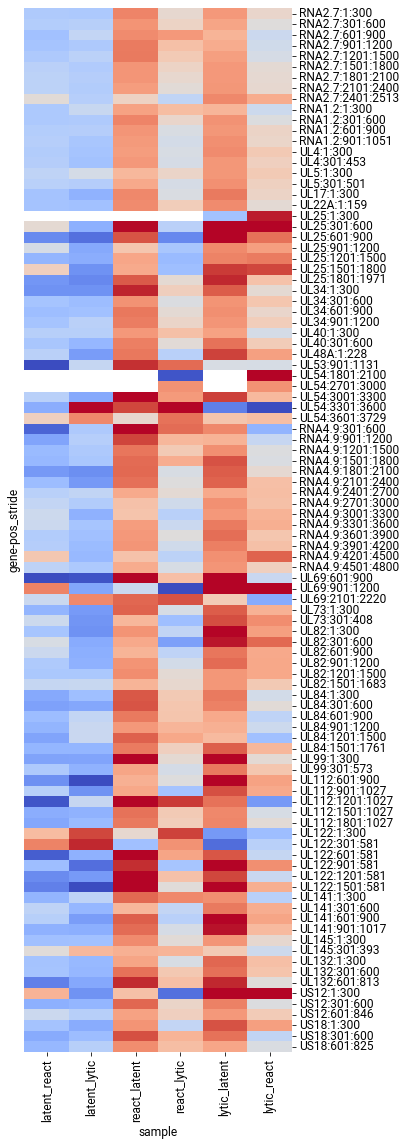

In [21]:
fig, ax = plt.subplots(figsize= (4.8,4.8*4))
clustermap = eligos2_stride[sample_names]
sns.heatmap(np.log2(clustermap), 
               vmin=-2, vmax=2, cmap = 'coolwarm',
              yticklabels=yticks, cbar=False)
plt.savefig('figure_2022/heatmap_virus_medoddR.pdf', bbox_inches='tight')

In [23]:
lnccolors = {
    'RNA2.7': [2362, 4874, '#82c91e', '-'],
    'RNA1.2': [6634, 7684, '#ffd43b', '-'],
    'RNA4.9': [93949, 98873, '#3bc9db', '+'],
    'RNA5.0': [155744,  161422 , '#e64980', '-'],
}

lncanno = pd.DataFrame(lnccolors,
                      index='start end color strand'.split(' '))
                      #columns=['name', 'start', 'end', 'color'])
lncanno = lncanno.T
lncanno

,start,end,color,strand
RNA2.7,2362,4874,#82c91e,-
RNA1.2,6634,7684,#ffd43b,-
RNA4.9,93949,98873,#3bc9db,+
RNA5.0,155744,161422,#e64980,-


462
0


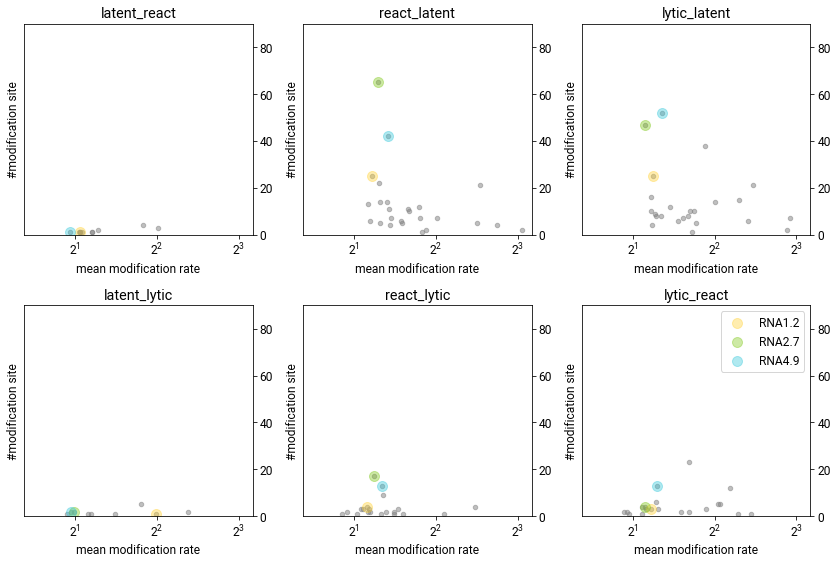

In [24]:
def plot_():
    plotdf = eligos2_filtered.copy()
    fig ,axes = plt.subplots(2,3, facecolor='white', figsize=(11.8,8))
    
    plotdf['gene'] = [identify_position(p, line['strand'], target_anno) for p, line in plotdf.iterrows()]
    print(len(plotdf))
    print(len(plotdf[plotdf['gene']=='no_match']))
    
    siggene = []
    """
    for sample in sample_names:
        
        df = plotdf[plotdf[sample]>=1.8]
        scatter_dict = {}
        for gene, line in target_anno.groupby('name'):
            totallength = abs(line['start'].min() - line['end'].max())
            sdf = df[df['gene']==gene]
            scatter_dict[gene] = [len(sdf), sdf[sample].replace(np.inf, 8).mean()]
        scatter_df = pd.DataFrame(scatter_dict, index='density mean'.split(' ')).fillna(0).T
       

        siggene.extend(scatter_df[(scatter_df['density']>=20)&(scatter_df['mean']>=2)].index.to_list())
    
    siggene = list(set(siggene))
    print(siggene)
    """
    siggene = lncanno.index[:-1]
    for pos, sample in zip([[0,0],[1,0],[0,1],[1,1],[0,2],[1,2]], sample_names):
        ax = axes[pos[0], pos[1]]
        df = plotdf[plotdf[sample]>=1.8]
        scatter_dict = {}
        for gene, line in target_anno.groupby('name'):
            totallength = abs(line['start'].min() - line['end'].max())
            sdf = df[df['gene']==gene]
            scatter_dict[gene] = len(sdf), sdf[sample].replace(np.inf, 8).mean()
        scatter_df = pd.DataFrame(scatter_dict, index='density mean'.split(' ')).fillna(0).T
        ax.scatter(scatter_df['mean'], scatter_df['density'], s=20, alpha=.5, c='grey')
        ax.set_ylabel('#modification site')
        ax.set_xlabel('mean modification rate')

        for _, line in scatter_df.iterrows():
            if _ in siggene:
                ax.scatter(line['mean'], line['density'], s=100, alpha=.4, label=_, c=lncanno.loc[_, 'color'])
#                ax.annotate(_, xy=(line['density'], line['mean']), fontsize=14)
 
        ax.set_ylim(0, 90)
        
        ax.set_xlim(1.3, 9)
        #ax.grid(which='both')
        ax.set_xscale('log', base=2)
        #ax.axvline(20, color='red', lw=1, ls='--', zorder=2)
        #ax.axhline(2, color='red', lw=1, ls='--', zorder=2)
        
        ax.set_title(sample)
    axes[1,2].legend()
    fig.tight_layout()
        
plot_()